In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sympy.polys.groebnertools import Polyn

df = pd.read_csv('X_train.csv')

trajectory_size = 258
indices_to_drop = []

for i in range(0, int((df.shape[0]) / trajectory_size)):
    start = (i * (trajectory_size - 1))
    end = (start + 1) + 255

    if end > df.shape[0]:
        break

    for j in range(start + 1, end):
        if np.isclose(df.at[j, 't'], 0.0, rtol=1e-09, atol=1e-09):
            indices_to_drop.extend(range(start, end + 1))
            break

df = df.drop(df.index[indices_to_drop])
print("Cleaned dataset shape:", df.shape)

df = df.sample(frac=0.2)

def compute_accelerations(df):
    ax = []
    ay = []    
    G = 1.0  
    masses = [1, 1, 1]  

    for index, row in df.iterrows():
        x1, y1 = row['x_1'], row['y_1']
        x2, y2 = row['x_2'], row['y_2']
        x3, y3 = row['x_3'], row['y_3']
        
        d12 = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
        d13 = np.sqrt((x1 - x3) ** 2 + (y1 - y3) ** 2)
        d23 = np.sqrt((x2 - x3) ** 2 + (y2 - y3) ** 2)

        ax1, ay1 = 0, 0
        ax2, ay2 = 0, 0
        ax3, ay3 = 0, 0

        if d12 > 0 and d13 > 0:
            ax1 = G * (masses[1] * (x2 - x1) / d12**3 + masses[2] * (x3 - x1) / d13**3)
            ay1 = G * (masses[1] * (y2 - y1) / d12**3 + masses[2] * (y3 - y1) / d13**3)

        if d12 > 0 and d23 > 0:
            ax2 = G * (masses[0] * (x1 - x2) / d12**3 + masses[2] * (x3 - x2) / d23**3)
            ay2 = G * (masses[0] * (y1 - y2) / d12**3 + masses[2] * (y3 - y2) / d23**3)

        if d13 > 0 and d23 > 0:
            ax3 = G * (masses[0] * (x1 - x3) / d13**3 + masses[1] * (x2 - x3) / d23**3)
            ay3 = G * (masses[0] * (y1 - y3) / d13**3 + masses[1] * (y2 - y3) / d23**3)

        ax.append([ax1, ax2, ax3])
        ay.append([ay1, ay2, ay3])

    ax = np.array(ax)
    ay = np.array(ay)

    df['ax_1'], df['ax_2'], df['ax_3'] = ax[:, 0], ax[:, 1], ax[:, 2]
    df['ay_1'], df['ay_2'], df['ay_3'] = ay[:, 0], ay[:, 1], ay[:, 2]
    print("Accelerations computed")

def compute_distances(df):
    df['d_12'] = np.sqrt((df['x_1'] - df['x_2'])**2 + (df['y_1'] - df['y_2'])**2)
    df['d_13'] = np.sqrt((df['x_1'] - df['x_3'])**2 + (df['y_1'] - df['y_3'])**2)
    df['d_23'] = np.sqrt((df['x_2'] - df['x_3'])**2 + (df['y_2'] - df['y_3'])**2)
    print("Distances computed")

compute_accelerations(df)
compute_distances(df)

selected_features = ['t', 'd_12', 'd_13', 'd_23', 'ax_1', 'ay_1', 'ax_2', 'ay_2', 'ax_3', 'ay_3']
targets = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

X = df[selected_features]
y = df[targets]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8)

Cleaned dataset shape: (1043420, 14)
Accelerations computed
Distances computed


In [3]:
def predictAndGenerateSubmissionCsv(model, title) :
    X_test_dataframe = pd.read_csv("X_test.csv").drop(columns=['Id'])
    X_test_dataframe = X_test_dataframe.rename(columns={'t': 't', 'x0_1': 'x_1', 'y0_1': 'y_1', 'x0_2': 'x_2', 'y0_2': 'y_2', 'x0_3': 'x_3', 'y0_3': 'y_3'})

    for i in range(1,4):
        X_test_dataframe['v_x_'+ str(i)] = 0.0
        X_test_dataframe['v_y_'+ str(i)] = 0.0
    
    X_test_dataframe = X_test_dataframe[X.columns]
    y_predicted = model.predict(X_test_dataframe)

    y_predicted_dataframe = pd.DataFrame(y_predicted, columns = X.columns)
    y_predicted_dataframe = pd.DataFrame(y_predicted_dataframe, columns = ['Id', 'x_1', 'y_1', 'x_2', 'y_2','x_3', 'y_3'])
    y_predicted_dataframe['Id'] = X_test_dataframe.index

    y_predicted_dataframe.to_csv(title + '_submission.csv', index=False)

In [19]:
def plot_y_yhat(y_val,y_pred, plot_title):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_val) > MAX:
        idx = np.random.choice(len(y_val),MAX, replace=False)
    else:
        idx = np.arange(len(y_val))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_val[idx,i])
        x1 = np.max(y_val[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_val[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig(plot_title + '.pdf')
    plt.show()

Y_pred_val shape: (41737, 6)
Validation RMSE: 1.0025


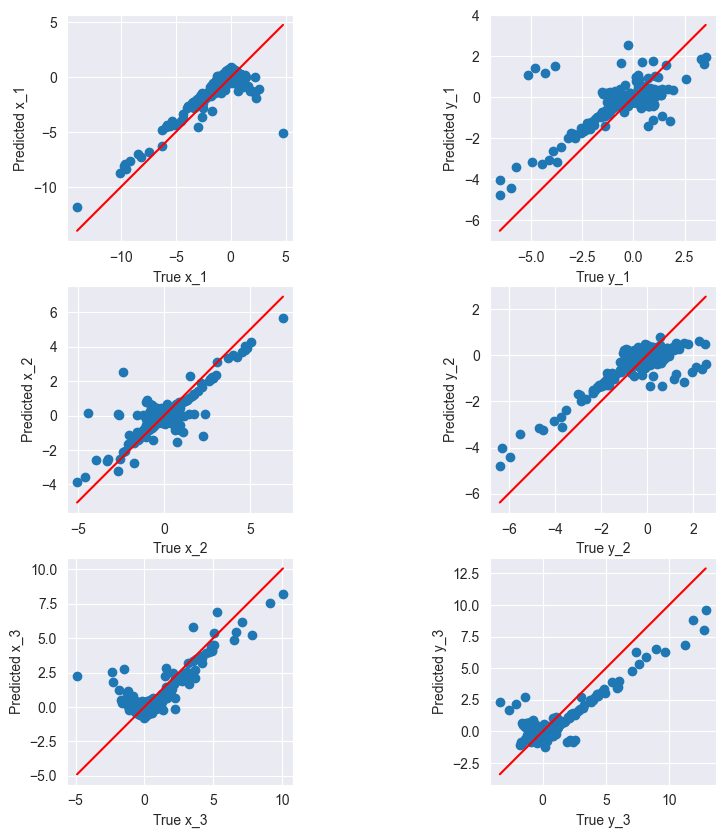

In [22]:
def linear_regression():
    model = make_pipeline(StandardScaler(), LinearRegression())
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    print("Y_pred_val shape:", y_pred_val.shape)

    rmse_val = root_mean_squared_error(y_val, y_pred_val)
    print(f"Validation RMSE: {rmse_val:.4f}")
    plot_y_yhat(y_val.values, y_pred_val, "linear_regression")

    #predictAndGenerateSubmissionCsv(model, "linear_regression")
    
linear_regression()

In [6]:
def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,4), max_features=None):
    if regressor is None:
        regressor = RidgeCV(alphas=[1.0])
    best_degree = None
    for degree in degrees:
        model = make_pipeline(PolynomialFeatures(degree), regressor)
        model.fit(X_train, y_train)
        y_pred_val = model.predict(X_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
        print(f"Validation RMSE for degree {degree}: {rmse_val:.4f}")
        if best_degree is None or rmse_val < best_rmse:
            best_rmse = rmse_val
            best_degree = degree
            best_model = model
    print(f"Best degree: {best_degree}")

validate_poly_regression(X_train, y_train, X_val, y_val)

Validation RMSE for degree 1: 1.0332
Validation RMSE for degree 2: 1898754972.0524
Validation RMSE for degree 3: 88853012517373429678080.0000


KeyboardInterrupt: 

Y_pred_val shape: (41737, 6)
Validation RMSE: 838515052974326963823968256.0000


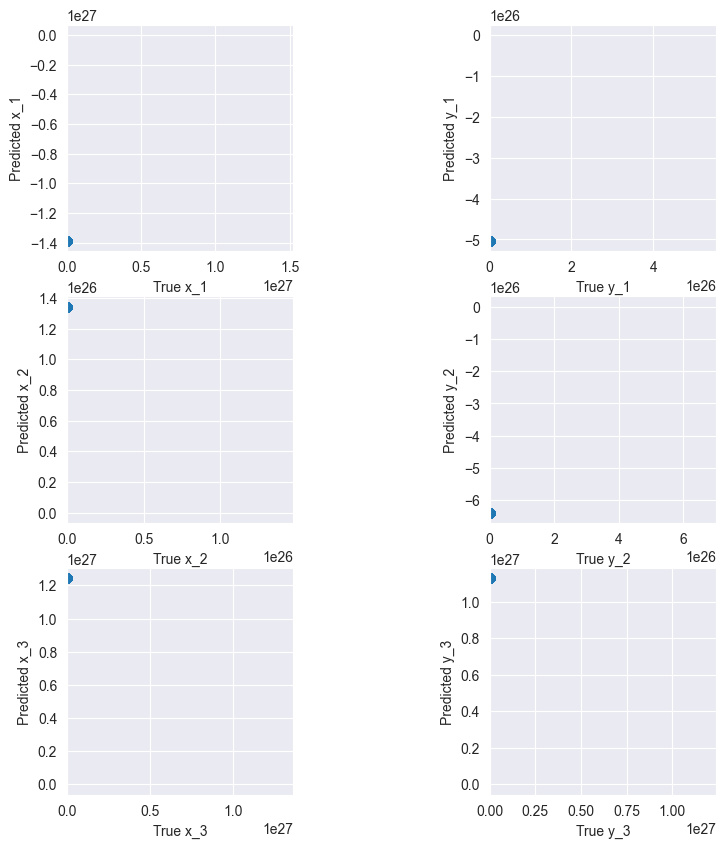

In [25]:
def polynomial_regression():
    degree = 3
    model = make_pipeline(PolynomialFeatures(degree), RidgeCV(alphas=[1.0]))
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    print("Y_pred_val shape:", y_pred_val.shape)
    rmse_val = root_mean_squared_error(y_val, y_pred_val)
    print(f"Validation RMSE: {rmse_val:.4f}")
    plot_y_yhat(y_val.values, y_pred_val, "polynomial_regression")

polynomial_regression()

In [5]:
def validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1,10)):
    best_k = None
    for k in k:
        model = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=k))
        model.fit(X_train, y_train)
        y_pred_val = model.predict(X_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
        print(f"Validation RMSE for k={k}: {rmse_val:.4f}")
        if best_k is None or rmse_val < best_rmse:
            best_rmse = rmse_val
            best_k = k
            best_model = model
    print(f"Best k: {best_k}")

validate_knn_regression(X_train, y_train, X_val, y_val)

Validation RMSE for k=1: 0.9465
Validation RMSE for k=2: 0.8497
Validation RMSE for k=3: 0.8287
Validation RMSE for k=4: 0.8198
Validation RMSE for k=5: 0.8147
Validation RMSE for k=6: 0.8111
Validation RMSE for k=7: 0.8096
Validation RMSE for k=8: 0.8101
Validation RMSE for k=9: 0.8063
Best k: 9


Y_pred_val shape: (41737, 6)
Validation RMSE: 0.8028


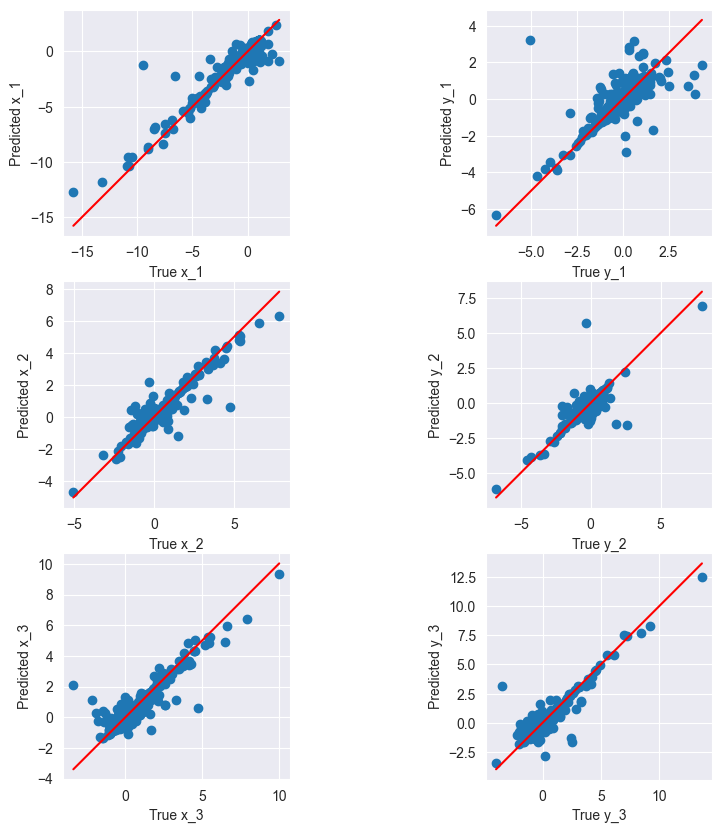

In [16]:
def knnSub():
    best_k = 9
    model = make_pipeline(KNeighborsRegressor(n_neighbors=best_k))
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    print("Y_pred_val shape:", y_pred_val.shape)
    rmse_val = root_mean_squared_error(y_val, y_pred_val)
    print(f"Validation RMSE: {rmse_val:.4f}")
    plot_y_yhat(y_val.values, y_pred_val, "knn")
    
    #predictAndGenerateSubmissionCsv(model, "knn")

knnSub()